In [316]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j0, j1, jv, i0
from scipy.special import jn_zeros
from scipy.integrate import quad
from scipy.integrate import simps
from scipy.integrate import dblquad
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D

ImportError: cannot import name 'simps' from 'scipy.integrate' (c:\Users\Омар\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\integrate\__init__.py)

## Constants and math functions

In [ ]:
H = 2
R = 1

z = np.linspace(0, H, 60)
r = np.linspace(0, R, 60)

max_k = 10
max_n = 10

In [ ]:
def I0(x):
    return i0(x)

def J0(x):
    return j0(x)

def J1(x):
    return j1(x)

def J2(x):
    return jv(2, x)

def find_beta_k_roots(max_k, R=1):
    # Находим первые max_k нулей функции Бесселя первого порядка J1
    j1_zeros = jn_zeros(1, max_k)
    # Вычисляем соответствующие β_k = j1_zero / R
    roots = j1_zeros / R
    return roots

In [ ]:
G = 80
LAMBDA = 120
mu_0 = (LAMBDA + G)/G
alpha = 45.0  

def a_k(k):
    return np.pi*(2 * k + 1) / 2

def lambda_n(n):
    return (np.pi * n) / H 

beta_k = find_beta_k_roots(max_k, R)

In [ ]:
j0bk = np.empty(max_k)
for k in range(max_k):
    j0bk[k] = J0(beta_k[k])

In [ ]:
ak = np.empty(max_k)
for k in range(0, max_k+1):
    ak[k-1] = a_k(k)

In [ ]:
lambdan = np.empty(max_n)
for k in range(0, max_n+1):
    lambdan[k-1] = lambda_n(k)

## Solutions

### Function $T$ of temperature

The solution of the mathematical model of the heat conduction problem
$$
T(r, z)=\sum^\infty_0\frac{I_0(a_kr)}{I_0(a_kR)}f_ksin(a_kz)
$$
Where
$$ 
f_k=\int^H_0f(z)sin(a_kz)dz 
$$

In [ ]:
def f(z):
    return -z**2+H*z

def f_k(k):
    integrand = lambda z: f(z) * np.sin(a_k(k) * z)
    integral = quad(integrand, 0, H)[0]
    return integral

In [ ]:
f_k_array = np.empty(max_k)
for k in range(1, max_k+1):
    result = f_k(k)
    f_k_array[k-1] = result 

In [ ]:
def T(r, z):
    sum = np.sum((f_k_array / I0(ak * R)) * I0(ak * r) * np.sin(ak * z))
    return (2 / H) * sum

$$
T_{nk}=\int^R_0J_0(\beta_kr)rdr\int^H_0T(r,z)cos(\lambda_nz)dz \\
\lambda_n=\frac{\pi n}{2},\ \ n=0,1,... \\
\beta_k \text{ - solutions of the equation: } J_0(\beta_kR)=0 
$$

In [ ]:
def T_nk(n, k, T_func):
    """
    Возвращает двойной интеграл
        ∫_{r=0}^R ∫_{z=0}^H T(r,z) * J0(beta_k[k] * r) * r * cos(lambdan[n] * z) dz dr
    """
    # Функция для dblquad: первый аргумент — z, второй — r
    def integrand(z, r):
        return T_func(r, z) * j0bk[k-1] * r * np.cos(lambdan[n-1] * z)

    # dblquad ожидает порядок: dblquad(func, r_min, r_max, z_min_fun, z_max_fun)
    result, error = dblquad(integrand,
                            0,     # r от 0
                            R,     # до R
                            lambda r: 0,  # для каждого r, z от 0
                            lambda r: H)  # до H
    return result

In [ ]:
T_nk_array = np.empty([max_n, max_k])
for n in range(1, max_n+1):
    for k in range(1, max_k+1):
        result = T_nk(n, k, T)
        print(n, k)
        T_nk_array[n-1, k-1] = result

TypeError: T_nk() takes 1 positional argument but 3 were given

### Functions $u(r, z)$ and $w(r, z)$

$$
u(r,z)=\frac{4\mu_0\alpha}{HR^2}
\left(\sum_{k=1}^\infty \frac{\beta_k}{\left(\beta^2_k+\lambda^2_n\right)}  \frac{J_1(\beta_{k}r)}{J_0^2(\beta_{k}R)}T_{0k}
+2\sum_{k=1}^{\infty}\frac{J_1(\beta_{k}r)}{J_0^2(\beta_{k}R)}
\sum_{k=1}^\infty \frac{\beta_k}{\left(\beta^2_k+\lambda^2_n\right)} 
cos(\lambda_nz)\right)T_{nk}
$$

In [ ]:
def u(r, z, max_k, max_n):
    sum_u = 0.0
    sum_u = np.sum((1 / beta_k) * (J1(beta_k * r) / J0(beta_k * R)**2) * T_nk_array[0])
    for n in range(1, max_n + 1):
        for k in range(1, max_k + 1):
            sum_u += 2 * (J1(beta_k[k-1] * r) / J0(beta_k[k-1] * R)**2) * (beta_k[k-1] / (beta_k[k-1]**2 + lambdan[n]**2)) * np.cos(lambdan[n] * z) * T_nk_array[n-1, k-1]
    return (4 * mu_0 * alpha) / (H * R**2) * sum_u

$$
w(r,z)
=-\frac{8\mu_0\alpha}{HR^2}
\sum_{k=1}^{\infty}\frac{J_0(\beta_{0k}r)}{J_0^2(\beta_{0k}R)}
\sum_{n=1}^\infty \frac{\lambda_n}{\left(\beta^2_k+\lambda^2_n\right)} sin(\lambda_nz)T_{nk}
$$

In [ ]:
def w(r, z, max_k, max_n):
    sum_w = 0.0
    for k in range(1, max_k + 1):
        for n in range(1, max_n + 1):
            sum_w += np.sin(lambdan[n] * z) * (J0(beta_k[k-1] * r) / J0(beta_k[k-1] * R)**2) * (lambdan[n] / (beta_k[k-1]**2 + lambdan[n]**2)) * T_nk_array[n-1, k-1]
    return (-8 * mu_0 * alpha) / (H * R**2) * sum_w

### Partial derivative's $u(r, z)$

$$
\frac{\partial u}{\partial r}(r,z)
=\frac{4\mu_0\alpha}{HR^2}
\sum_{k=1}^{\infty}\frac{J_0(\beta_{k}r)-J_2(\beta_{k}r)}{J_0^2(\beta_{k}R)}
\sum_{n=0}^\infty \frac{\beta_k}{\left(\beta^2_k+\lambda^2_n\right)} 
cos(\lambda_nz)T_{nk}
$$

In [ ]:
def partial_u_r(r, z, max_k, max_n):
    sum_u_r = 0.0
    for k in range(1, max_k + 1):
        for n in range(0, max_n + 1):
            sum_u_r += (J0(beta_k[k-1] * r) - J2(beta_k[k-1] * r)) / J0(beta_k[k-1] * R)**2 * (beta_k[k-1] / (beta_k[k-1]**2 + lambdan[n]**2)) * np.cos(lambdan[n] * z) * T_nk_array[n-1, k-1]
    return (4 * mu_0 * alpha) / (H * R**2) * sum_u_r

$$
\frac{\partial u}{\partial z}(r,z)
=-\frac{8\mu_0\alpha}{HR^2}
\sum_{k=1}^{\infty}\frac{J_1(\beta_{k}r)}{J_0^2(\beta_{k}R)}
\sum_{n=1}^\infty \frac{\lambda_n\beta_k}{\left(\beta^2_k+\lambda^2_n\right)} sin(\lambda_nz)T_{nk}
$$

In [ ]:
def partial_u_z(r, z, max_k, max_n):
    sum_u_z = 0.0
    for k in range(1, max_k + 1):
        for n in range(1, max_n + 1):
            sum_u_z += J1(beta_k[k-1] * r) / J0(beta_k[k-1] * R)**2 * (lambdan[n] * beta_k[k-1] / (beta_k[k-1]**2 + lambdan[n]**2)) * np.sin(lambdan[n] * z)  * T_nk_array[n-1, k-1]
    return (-8 * mu_0 * alpha) / (H * R**2) * sum_u_z

### Partial derivative's $w(r, z)$

$$
\frac{\partial w}{\partial r}(r,z)
=\frac{8\mu_0\alpha}{HR^2}
\sum_{k=1}^{\infty}\frac{J_1(\beta_{k}r)}{J_0^2(\beta_{k}R)}
\sum_{n=1}^\infty \frac{\lambda_n}{\left(\beta^2_k+\lambda^2_n\right)} sin(\lambda_nz)T_{nk}
$$

In [ ]:
def partial_w_r(r, z, max_k, max_n):
    sum_w_r = 0.0
    for k in range(1, max_k + 1):
        for n in range(1, max_n + 1):
            sum_w_r += J1(beta_k[k-1] * r) / J0(beta_k[k-1] * R)**2 * (lambdan[n] / (beta_k[k-1]**2 + lambdan[n]**2)) * np.sin(lambdan[n] * z) * T_nk_array[n-1, k-1]
    return (8 * mu_0 * alpha) / (H * R**2) * sum_w_r

$$
\frac{\partial w}{\partial z}(r,z)
=-\frac{8\mu_0\alpha}{HR^2}
\sum_{k=1}^{\infty}\frac{J_0(\beta_{k}r)}{J_0^2(\beta_{k}R)}
\sum_{n=1}^\infty \frac{\lambda^2_n}{\left(\beta^2_k+\lambda^2_n\right)} cos(\lambda_nz)T_{nk}
$$

In [ ]:
def partial_w_z(r, z, max_k, max_n):
    sum_w_z = 0.0
    for k in range(1, max_k + 1):
        for n in range(1, max_n + 1):
            sum_w_z += J0(beta_k[k-1] * r) / J0(beta_k[k-1] * R)**2 * (lambdan[n]**2 / (beta_k[k-1]**2 + lambdan[n]**2)) * np.cos(lambdan[n] * z) * T_nk_array[n-1, k-1]
    return (-8 * mu_0 * alpha) / (H * R**2) * sum_w_z

### Voltages $\Theta(r, z),\  \sigma_r(r, z),\  \sigma_z(r, z)$

In [ ]:
def theta(r, z, max_k, max_n):
    return partial_u_r(r, z, max_k, max_n) + 1/r * u(r, z, max_k, max_n) + partial_w_r(r, z, max_k, max_n)

In [ ]:
def sigma_r(r, z, max_k, max_n):
    return 2 * G * (partial_u_r(r, z, max_k, max_n) + mu_0/(1-2*mu_0)*theta(r, z, max_k, max_n))

In [ ]:
def sigma_z(r, z, max_k, max_n):
    return 2 * G * (partial_w_z(r, z, max_k, max_n) + mu_0/(1-2*mu_0)*theta(r, z, max_k, max_n))

## Plot boundary conditions

In [ ]:
def plot2d(x, y, xlim, xlabel="", ylabel="", title="", plot=plt):
    plot.plot(x, y)
    if plot is plt:
        plot.xlim(0, xlim)
        plot.xlabel(xlabel)
        plot.ylabel(ylabel)
        plot.title(title)
    else:
        plot.grid()
        plot.set_xlim(0, xlim)
        plot.set_xlabel(xlabel)
        plot.set_ylabel(ylabel)
        plot.set_title(title)


$$w(r, 0)=0$$
$$\frac{\partial u}{\partial z}|_{z=0}=0$$
$$w(r, H)=0$$
$$\frac{\partial u}{\partial z}|_{z=H}=0$$
$$u(R, z)=0$$
$$\frac{\partial w}{\partial r}|_{r=R}=0$$

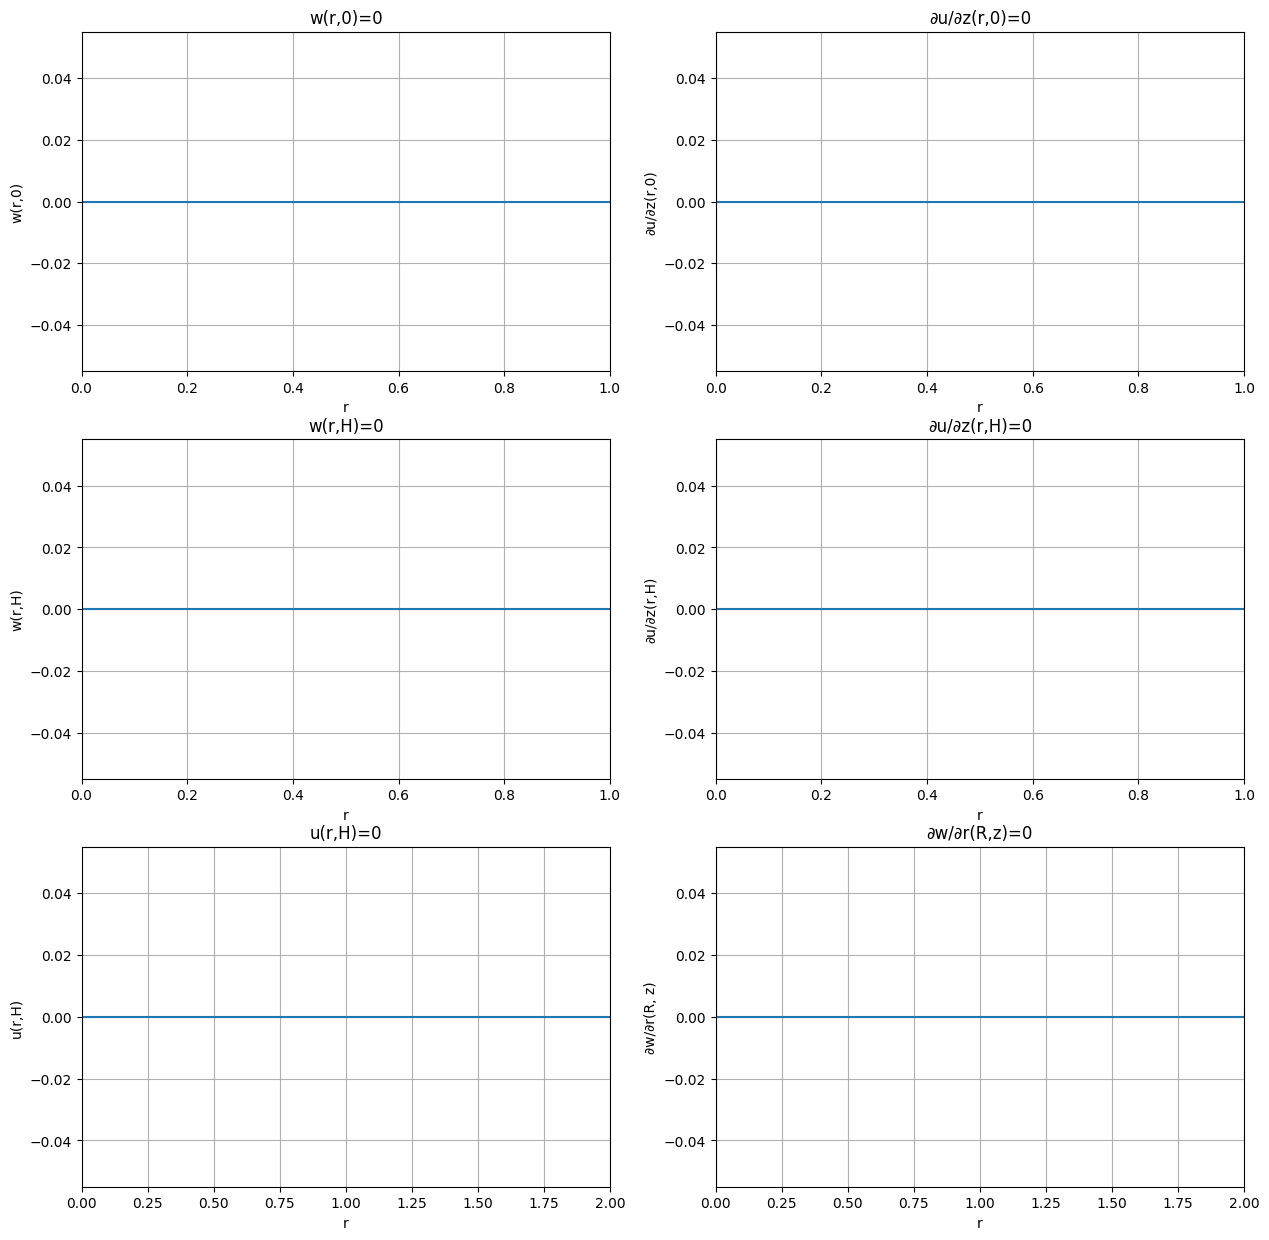

In [ ]:
figure, axis = plt.subplots(3, 2)
figure.set_figheight(15)
figure.set_figwidth(15)

plot2d(r, w(r, 0, max_k, max_n), R, "r", "w(r,0)", "w(r,0)=0", axis[0, 0])
plot2d(r, partial_u_z(r, 0, max_k, max_n), R, "r", "∂u/∂z(r,0)", "∂u/∂z(r,0)=0", axis[0, 1])
plot2d(r, np.round(w(r, H, max_k, max_n), 9), R, "r", "w(r,H)", "w(r,H)=0", axis[1, 0])
plot2d(r, np.round(partial_u_z(r, H, max_k, max_n), 9), R, "r", "∂u/∂z(r,H)", "∂u/∂z(r,H)=0", axis[1, 1]) 
plot2d(z, np.round(u(R, z, max_k, max_n), 9), H, "r", "u(r,H)", "u(r,H)=0", axis[2, 0])
plot2d(z, np.round(partial_w_r(R, z, max_k, max_n), 9), H, "r", "∂w/∂r(R, z)", "∂w/∂r(R,z)=0", axis[2, 1])

## Plot solutions

In [ ]:
def plot3d(r, z, f, rlabel='r', zlabel='z', title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlim(r[0], r[-1])
    ax.set_ylim(z[0], z[-1])
    
    r3d, z3d = np.meshgrid(r, z)
    
    print(np.max(f(r3d, z3d, max_k, max_n)))

    ax.plot_surface(r3d, z3d, np.round(f(r3d, z3d, max_k, max_n), 9), cmap='viridis')

    ax.set_title(title)
    ax.set_xlabel(rlabel)
    ax.set_ylabel(zlabel)

1.0754999112071524


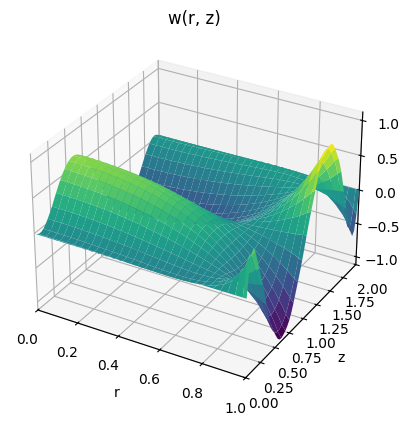

In [ ]:
plot3d(r, z, w, title="w(r, z)")

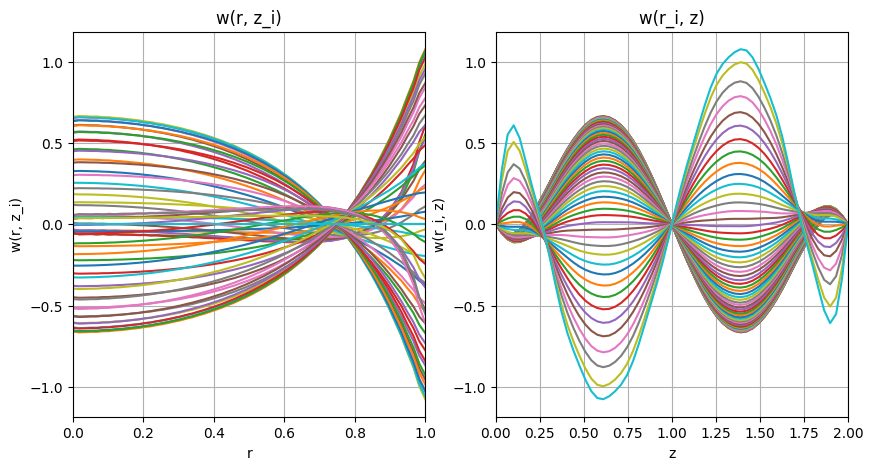

In [ ]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

axis[0].grid()
axis[1].grid()

for i in z:
    plot2d(r, np.round(w(r, i, max_k, max_n), 9), R, "r", "w(r, z_i)", "w(r, z_i)", plot=axis[0])

for i in r:
    plot2d(z, np.round(w(i, z, max_k, max_n), 9), H, "z", "w(r_i, z)", "w(r_i, z)", plot=axis[1])

0.6415469163633771


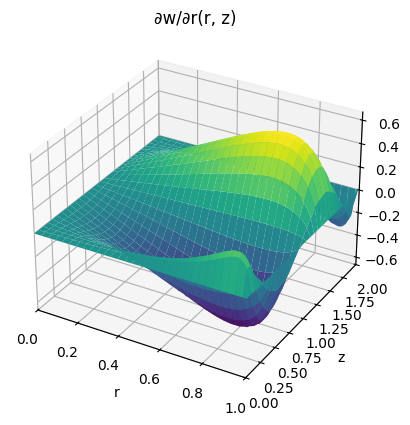

In [ ]:
plot3d(r, z, partial_w_r, title="∂w/∂r(r, z)")

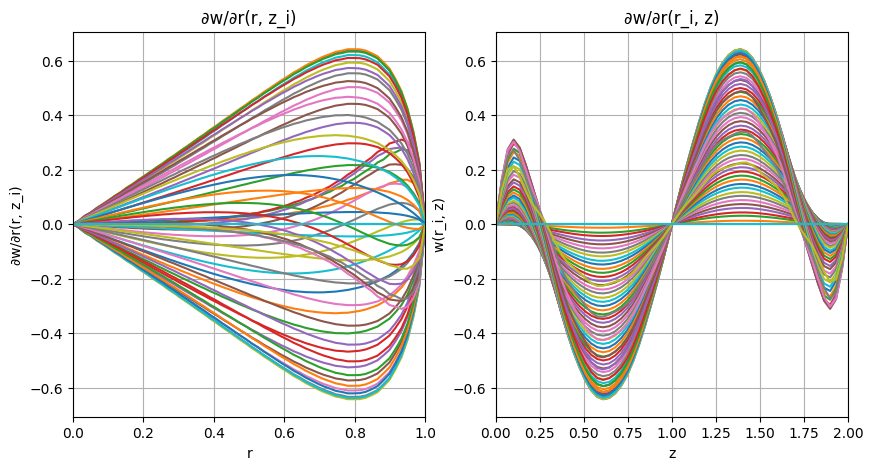

In [ ]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

axis[0].grid()
axis[1].grid()

for i in z:
    plot2d(r, np.round(partial_w_r(r, i, max_k, max_n), 9), R, "r", "∂w/∂r(r, z_i)", "∂w/∂r(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(partial_w_r(i, z, max_k, max_n), 9), H, "z", "w(r_i, z)", "∂w/∂r(r_i, z)", plot=axis[1])

10.438752018027024


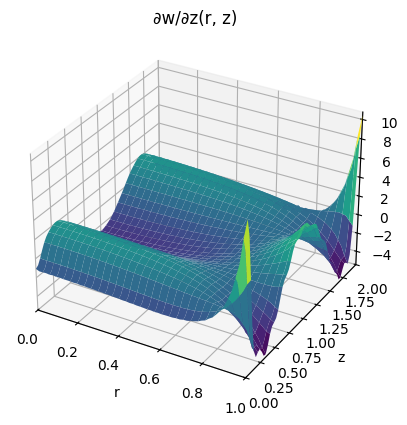

In [ ]:
plot3d(r, z, partial_w_z, title="∂w/∂z(r, z)")

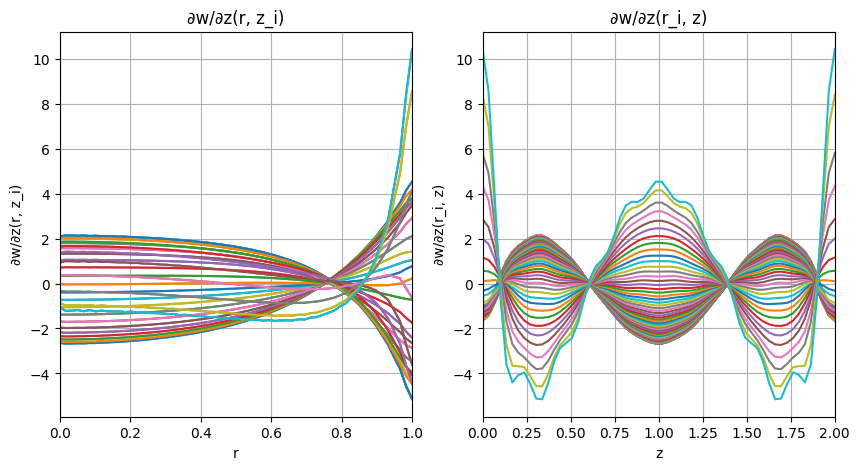

In [ ]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

axis[0].grid()
axis[1].grid()

for i in z:
    plot2d(r, np.round(partial_w_z(r, i, max_k, max_n), 9), R, "r", "∂w/∂z(r, z_i)", "∂w/∂z(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(partial_w_z(i, z, max_k, max_n), 9), H, "z", "∂w/∂z(r_i, z)", "∂w/∂z(r_i, z)", plot=axis[1])

2.0086069557668957


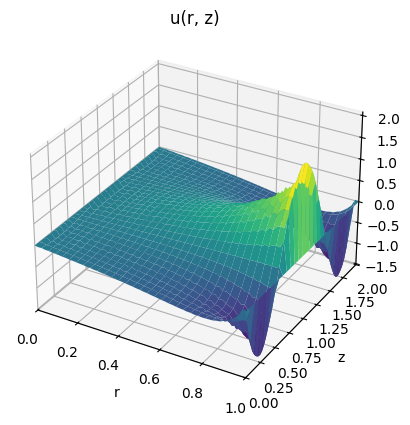

In [ ]:
plot3d(r, z, u, title="u(r, z)")

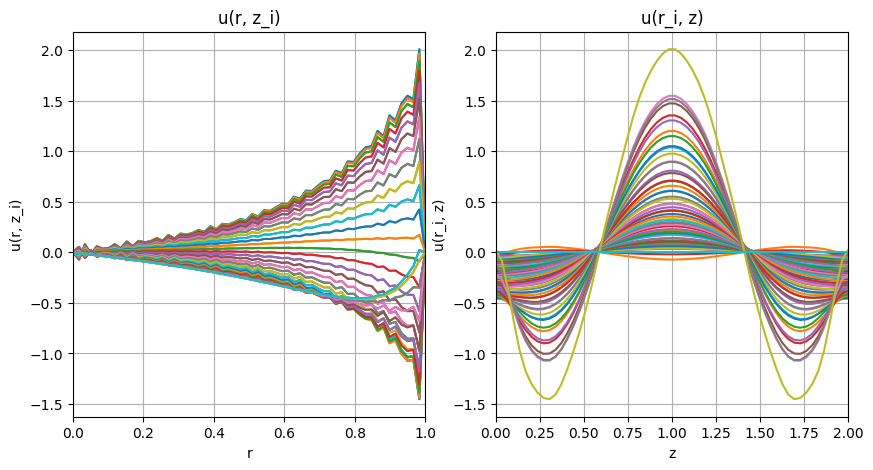

In [ ]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

axis[0].grid()
axis[1].grid()

for i in z:
    plot2d(r, np.round(u(r, i, max_k, max_n), 9), R, "r", "u(r, z_i)", "u(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(u(i, z, max_k, max_n), 9), H, "z", "u(r_i, z)", "u(r_i, z)", plot=axis[1])

2.838604945381962


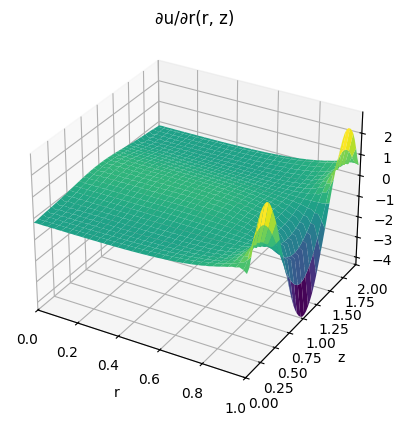

In [ ]:
plot3d(r, z, partial_u_r, title="∂u/∂r(r, z)")

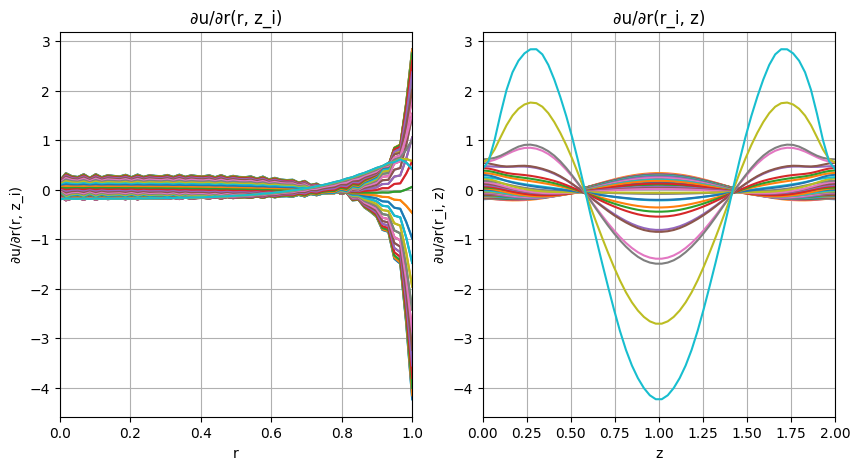

In [ ]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

axis[0].grid()
axis[1].grid()

for i in z:
    plot2d(r, np.round(partial_u_r(r, i, max_k, max_n), 9), R, "r", "∂u/∂r(r, z_i)", "∂u/∂r(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(partial_u_r(i, z, max_k, max_n), 9), H, "z", "∂u/∂r(r_i, z)", "∂u/∂r(r_i, z)", plot=axis[1])

9.555251389625585


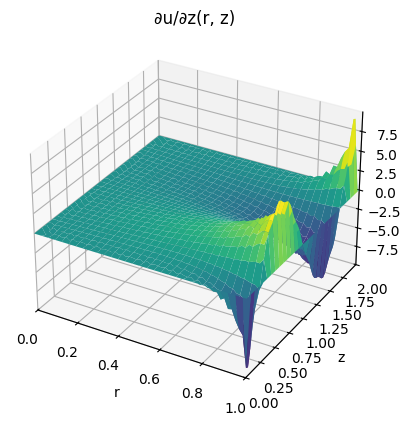

In [ ]:
plot3d(r, z, partial_u_z, title="∂u/∂z(r, z)")

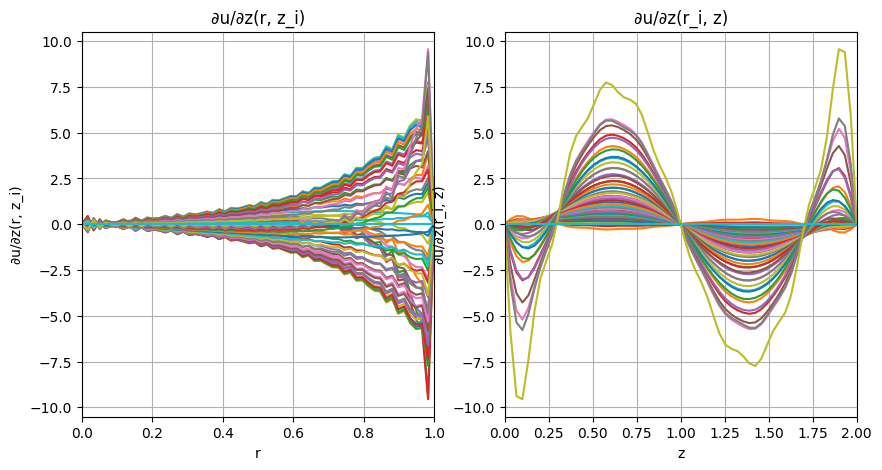

In [ ]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

axis[0].grid()
axis[1].grid()

for i in z:
    plot2d(r, np.round(partial_u_z(r, i, max_k, max_n), 9), R, "r", "∂u/∂z(r, z_i)", "∂u/∂z(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(partial_u_z(i, z, max_k, max_n), 9), H, "z", "∂u/∂z(r_i, z)", "∂u/∂z(r_i, z)", plot=axis[1])

## Plot voltages functions

In [ ]:
r = r[1:]
z = z[1:]

3.0120769105086636


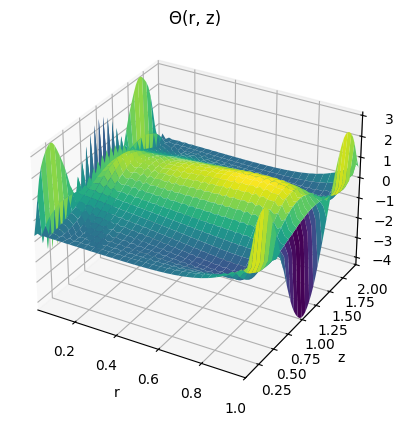

In [ ]:
plot3d(r, z, theta, title="Θ(r, z)")

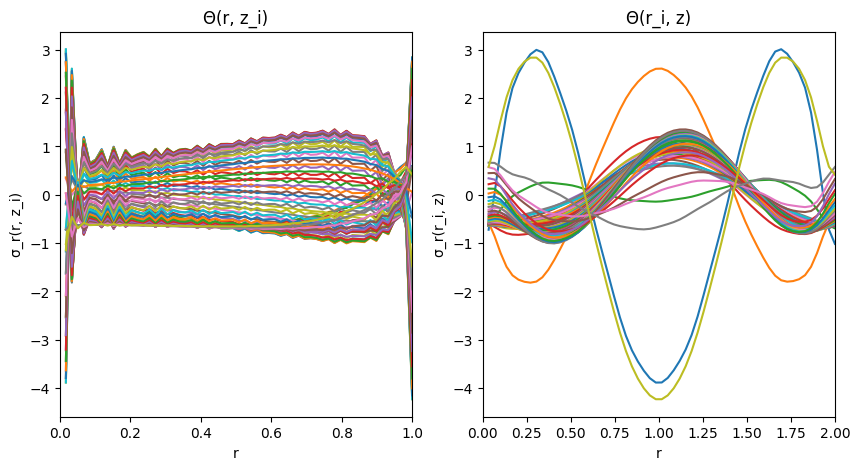

In [ ]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

axis[0].grid()
axis[1].grid()

for i in z:
    plot2d(r, np.round(theta(r, i, max_k, max_n), 9), R, "r", "σ_r(r, z_i)", "Θ(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(theta(i, z, max_k, max_n), 9), H, "r", "σ_r(r_i, z)", "Θ(r_i, z)", plot=axis[1])

442.2329154754896


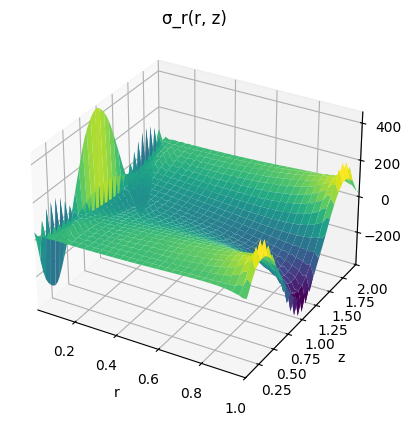

In [ ]:
plot3d(r, z, sigma_r, title="σ_r(r, z)")

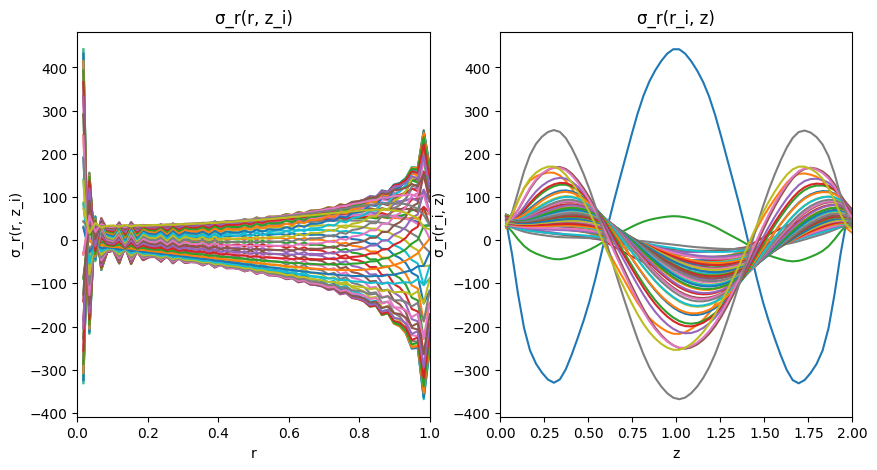

In [ ]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

axis[0].grid()
axis[1].grid()

for i in z:
    plot2d(r, np.round(sigma_r(r, i, max_k, max_n), 9), R, "r", "σ_r(r, z_i)", "σ_r(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(sigma_r(i, z, max_k, max_n), 9), H, "z", "σ_r(r_i, z)", "σ_r(r_i, z)", plot=axis[1])

1628.470769141626


KeyboardInterrupt: 

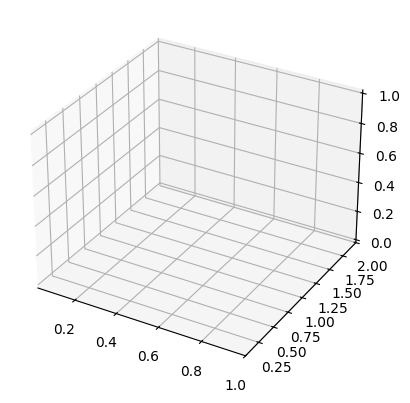

In [ ]:
plot3d(r, z, sigma_z, title="σ_z(r, z)")

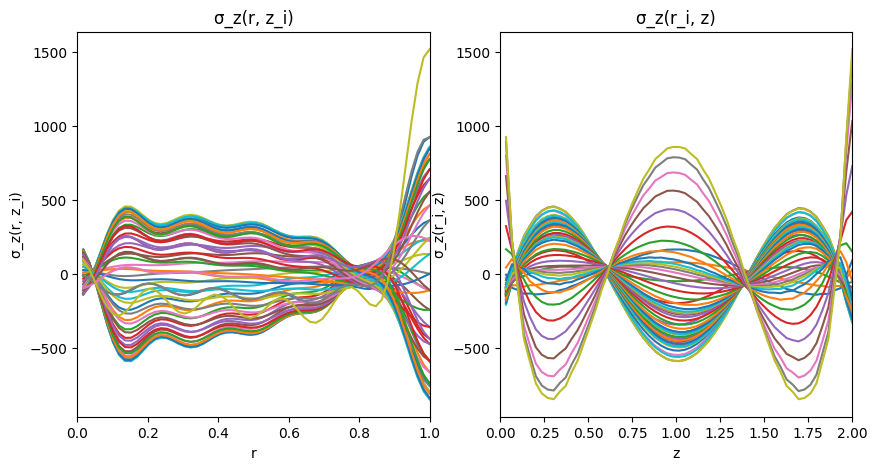

In [ ]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

axis[0].grid()
axis[1].grid()

for i in z:
    plot2d(r, np.round(sigma_z(r, i, max_k, max_n), 9), R, "r", "σ_z(r, z_i)", "σ_z(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(sigma_z(i, z, max_k, max_n), 9), H, "z", "σ_z(r_i, z)", "σ_z(r_i, z)", plot=axis[1])

## Cylinder's visualization

In [ ]:
def draw_cylinder(colors=['red', 'blue', 'blue'] ,radius=1, height=2, resolution=30):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Генерация координат для боковой поверхности
    theta = np.linspace(0, 2 * np.pi, resolution)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    z_bottom = np.zeros_like(x)
    z_top = np.ones_like(x) * height
    
    # Рисуем боковую поверхность
    for i in range(len(x) - 1):
        verts = [[(x[i], y[i], z_bottom[i]),
                  (x[i+1], y[i+1], z_bottom[i+1]),
                  (x[i+1], y[i+1], z_top[i+1]),
                  (x[i], y[i], z_top[i])]]
        ax.add_collection3d(Poly3DCollection(verts, color=colors[0], edgecolor='k'))
    
    # Рисуем верхнюю и нижнюю крышки
    ax.add_collection3d(Poly3DCollection([list(zip(x, y, z_bottom))], color=colors[1], edgecolor='k'))
    ax.add_collection3d(Poly3DCollection([list(zip(x, y, z_top))], color=colors[2], edgecolor='k'))
    
    # Настройки осей
    ax.set_xlim([-radius, radius])
    ax.set_ylim([-radius, radius])
    ax.set_zlim([0, height])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_box_aspect([1, 1, height / radius])
    
    plt.show()

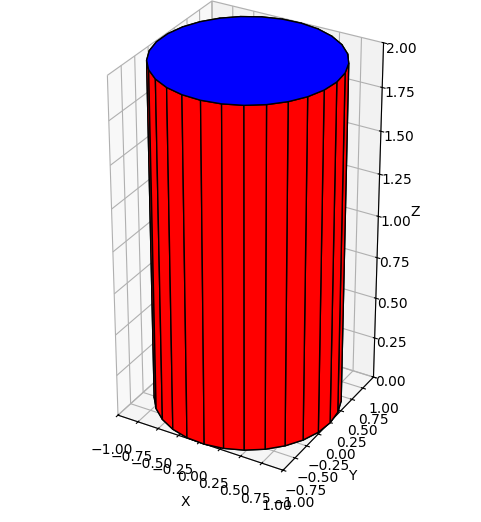

In [ ]:
draw_cylinder()

In [ ]:
draw_cylinder(['green', 'green', 'green'])

KeyboardInterrupt: 

In [ ]:
def draw_pol_cylinder(outer_radius=1, inner_radius=0.7, height=2, resolution=30):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Генерация координат для внешней и внутренней боковых поверхностей
    theta = np.linspace(0, 2 * np.pi, resolution)
    outer_x = outer_radius * np.cos(theta)
    outer_y = outer_radius * np.sin(theta)
    inner_x = inner_radius * np.cos(theta)
    inner_y = inner_radius * np.sin(theta)
    z_bottom = np.zeros_like(outer_x)
    z_top = np.ones_like(outer_x) * height
    
    # Рисуем внешнюю боковую поверхность
    for i in range(len(outer_x) - 1):
        verts = [[(outer_x[i], outer_y[i], z_bottom[i]),
                  (outer_x[i+1], outer_y[i+1], z_bottom[i+1]),
                  (outer_x[i+1], outer_y[i+1], z_top[i+1]),
                  (outer_x[i], outer_y[i], z_top[i])]]
        ax.add_collection3d(Poly3DCollection(verts, color='green', edgecolor='k'))
    
    # Рисуем внутреннюю боковую поверхность
    for i in range(len(inner_x) - 1):
        verts = [[(inner_x[i], inner_y[i], z_bottom[i]),
                  (inner_x[i+1], inner_y[i+1], z_bottom[i+1]),
                  (inner_x[i+1], inner_y[i+1], z_top[i+1]),
                  (inner_x[i], inner_y[i], z_top[i])]]
        ax.add_collection3d(Poly3DCollection(verts, color='green', edgecolor='k'))
    
    # Рисуем верхнюю и нижнюю крышки как кольца
    ax.add_collection3d(Poly3DCollection([list(zip(outer_x, outer_y, z_bottom)) + list(zip(inner_x[::-1], inner_y[::-1], z_bottom))], color='green', edgecolor='k'))
    ax.add_collection3d(Poly3DCollection([list(zip(outer_x, outer_y, z_top)) + list(zip(inner_x[::-1], inner_y[::-1], z_top))], color='green', edgecolor='k'))
    
    # Настройки осей
    ax.set_xlim([-outer_radius, outer_radius])
    ax.set_ylim([-outer_radius, outer_radius])
    ax.set_zlim([0, height])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_box_aspect([1, 1, height / outer_radius])
    
    plt.show()


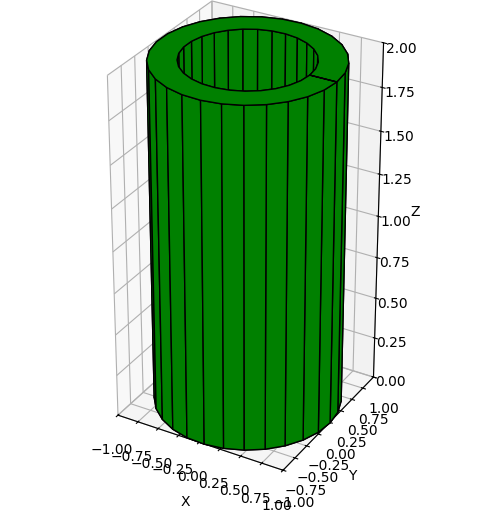

In [ ]:
draw_pol_cylinder()